# PLANT AND WEED CLASSIFICATION

In [96]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
import tensorflow as tf
import keras
import glob
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import csv

**Here I did some data exploration,number of classes,samples in each class,and the mean,max and min height and width of images in each class.**
**As we can see the images show huge variance in sizes,which is a drawback,especially since we are using CNN.**

In [45]:
plants=os.listdir('../nishant/Desktop/train/')
path='../nishant/Desktop/train/'
print plants
meanl=[]
meanw=[]
minl=[]
minw=[]
maxl=[]
maxw=[]
for k in plants:
   leng=[]
   wid=[]
   l=os.listdir(path+k)
   for j in l:
       im=cv2.imread(path+k+'/'+j)
       leng.append(im.shape[0])
       wid.append(im.shape[1])
   meanl.append(int(sum(leng)/len(leng)))
   meanw.append(int(sum(wid)/len(wid)))
   minl.append(int(min(leng)))
   minw.append(int(min(wid)))
   maxl.append(int(max(leng)))
   maxw.append(int(max(leng)))
print meanl,meanw,maxl,maxw,minl,minw

#for x in range ()


['Scentless Mayweed', 'Fat Hen', 'Sugar beet', 'Small-flowered Cranesbill', 'Shepherds Purse', 'Black-grass', 'Charlock', 'Common Chickweed', 'Maize', 'Cleavers', 'Common wheat', 'Loose Silky-bent']
[226, 303, 590, 342, 288, 661, 431, 230, 483, 310, 440, 397] [226, 303, 591, 342, 288, 668, 431, 230, 483, 310, 440, 399] [1227, 1273, 1715, 1006, 1317, 2670, 1582, 718, 1900, 866, 1432, 3457] [1227, 1273, 1715, 1006, 1317, 2670, 1582, 718, 1900, 866, 1432, 3457] [49, 55, 49, 62, 63, 73, 121, 54, 54, 66, 51, 71] [49, 55, 49, 62, 63, 73, 121, 54, 54, 66, 51, 71]


In [46]:
#for k in plants:
 #  leng=[]
 #  wid=[]
 #  print path+k
 #  l=os.listdir(path+k)
 #  for j in l:
   #  print path+k+j

### Loading training data
**using this function,we load the images along with one hot encoded labels,resize the images to 100,100(hyperparameter,needs to be optimised)and then normalise the image.**

In [60]:
def load_train(path,plants,size):
    images=[]
    labels=[]
    ids=[]
    clas=[]
    for fold in plants:
        index=plants.index(fold)
        pat = os.path.join(path, fold)
        files = glob.glob(pat+'/*')
        for f1 in files:
            im=cv2.imread(f1)
            image = cv2.resize(im, (size, size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(plants))
            label[index] = 1.0
            labels.append(label)
            #filename = os.path.basename(f1)
            #ids.append(filename)
            #clas.append(fold)
    images = np.array(images)
    labels = np.array(labels)
        #ids = np.array(ids)
        #cls = np.array(cls)
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    return images,labels


Ran the block below for loading training set

In [61]:
plants=os.listdir('../nishant/Desktop/train/')
path='../nishant/Desktop/train/'
img_train,y_train=load_train(path,plants,100)

In [66]:
print img_train.shape,y_train.shape

(4750, 100, 100, 3) (4750, 12)


### Train test split

In [67]:
x_train,x_test,y_train,y_test=train_test_split(img_train,y_train,test_size=0.25,random_state=7)
print x_train.shape,x_test.shape

(3562, 100, 100, 3) (1188, 100, 100, 3)


**setting CNN parameters**

In [68]:
batch_size = 32
num_classes = 12
epochs = 200
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'plant_detection_trained_model.h5'

### Defining the model

In [69]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

**Defining optimiser**

In [70]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

compiling model

In [71]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

**Data augmentation,added shifts and flips to the data to create more data**

In [72]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images


In [73]:
datagen.fit(x_train)

### Fitting our model on our data(runtime about 1.5 hrs on laptop)

In [74]:
model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4,verbose=1)

Epoch 1/200
111/111 [==============================] - 31s - loss: 2.3807 - acc: 0.1869 - val_loss: 2.2060 - val_acc: 0.2820
Epoch 2/200
111/111 [==============================] - 17s - loss: 1.9713 - acc: 0.3291 - val_loss: 1.7924 - val_acc: 0.4082
Epoch 3/200
111/111 [==============================] - 17s - loss: 1.7448 - acc: 0.3885 - val_loss: 1.5990 - val_acc: 0.5076
Epoch 4/200
111/111 [==============================] - 17s - loss: 1.6198 - acc: 0.4446 - val_loss: 1.4138 - val_acc: 0.5530
Epoch 5/200
111/111 [==============================] - 16s - loss: 1.5236 - acc: 0.4748 - val_loss: 1.2752 - val_acc: 0.5943
Epoch 6/200
111/111 [==============================] - 17s - loss: 1.3915 - acc: 0.5184 - val_loss: 1.3567 - val_acc: 0.5497
Epoch 7/200
111/111 [==============================] - 16s - loss: 1.3404 - acc: 0.5360 - val_loss: 1.1455 - val_acc: 0.6187
Epoch 8/200
111/111 [==============================] - 16s - loss: 1.2654 - acc: 0.5686 - val_loss: 1.0367 - val_acc: 0.6448


111/111 [==============================] - 16s - loss: 0.4476 - acc: 0.8482 - val_loss: 0.4440 - val_acc: 0.8611
Epoch 67/200
111/111 [==============================] - 16s - loss: 0.4387 - acc: 0.8561 - val_loss: 0.4968 - val_acc: 0.8527
Epoch 68/200
111/111 [==============================] - 16s - loss: 0.4684 - acc: 0.8472 - val_loss: 0.4214 - val_acc: 0.8721
Epoch 69/200
111/111 [==============================] - 16s - loss: 0.4295 - acc: 0.8540 - val_loss: 0.4550 - val_acc: 0.8611
Epoch 70/200
111/111 [==============================] - 16s - loss: 0.4358 - acc: 0.8571 - val_loss: 0.4386 - val_acc: 0.8670
Epoch 71/200
111/111 [==============================] - 16s - loss: 0.4515 - acc: 0.8496 - val_loss: 0.4164 - val_acc: 0.8729
Epoch 72/200
111/111 [==============================] - 16s - loss: 0.4280 - acc: 0.8535 - val_loss: 0.4167 - val_acc: 0.8712
Epoch 73/200
111/111 [==============================] - 16s - loss: 0.4477 - acc: 0.8556 - val_loss: 0.4655 - val_acc: 0.8611
Epoch

111/111 [==============================] - 16s - loss: 0.3708 - acc: 0.8789 - val_loss: 0.3662 - val_acc: 0.8914
Epoch 131/200
111/111 [==============================] - 16s - loss: 0.3670 - acc: 0.8893 - val_loss: 0.4328 - val_acc: 0.8721
Epoch 132/200
111/111 [==============================] - 16s - loss: 0.3733 - acc: 0.8780 - val_loss: 0.3581 - val_acc: 0.8973
Epoch 133/200
111/111 [==============================] - 16s - loss: 0.3359 - acc: 0.8826 - val_loss: 0.3711 - val_acc: 0.8914
Epoch 134/200
111/111 [==============================] - 16s - loss: 0.3977 - acc: 0.8732 - val_loss: 0.4037 - val_acc: 0.8779
Epoch 135/200
111/111 [==============================] - 16s - loss: 0.3881 - acc: 0.8770 - val_loss: 0.4196 - val_acc: 0.8636
Epoch 136/200
111/111 [==============================] - 16s - loss: 0.3506 - acc: 0.8851 - val_loss: 0.3917 - val_acc: 0.8805
Epoch 137/200
111/111 [==============================] - 16s - loss: 0.3545 - acc: 0.8826 - val_loss: 0.4137 - val_acc: 0.883

111/111 [==============================] - 16s - loss: 0.3160 - acc: 0.8921 - val_loss: 0.3526 - val_acc: 0.8956
Epoch 195/200
111/111 [==============================] - 16s - loss: 0.3409 - acc: 0.8942 - val_loss: 0.3351 - val_acc: 0.9066
Epoch 196/200
111/111 [==============================] - 16s - loss: 0.3131 - acc: 0.8963 - val_loss: 0.4100 - val_acc: 0.8813
Epoch 197/200
111/111 [==============================] - 16s - loss: 0.3334 - acc: 0.8968 - val_loss: 0.3273 - val_acc: 0.8981
Epoch 198/200
111/111 [==============================] - 16s - loss: 0.3011 - acc: 0.8983 - val_loss: 0.3852 - val_acc: 0.8956
Epoch 199/200
111/111 [==============================] - 16s - loss: 0.3169 - acc: 0.8966 - val_loss: 0.3904 - val_acc: 0.8830
Epoch 200/200
111/111 [==============================] - 16s - loss: 0.3367 - acc: 0.8949 - val_loss: 0.3377 - val_acc: 0.8990


**saving the model**

In [75]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Saved trained model at /home/nishant/saved_models/plant_detection_trained_model.h5 


**Loading test data**

In [79]:
def load_test(path,size):
  files = sorted(glob.glob(path+'/*'))
  X_test=[]
  X_test_id=[]
  for f in files:
      filename = os.path.basename(f)
      img = cv2.imread(f)
      img = cv2.resize(img, (size, size), cv2.INTER_LINEAR)
      X_test.append(img)
      X_test_id.append(filename)

  X_test = np.array(X_test, dtype=np.uint8)
  X_test = X_test.astype('float32')
  X_test = X_test / 255

  return X_test, X_test_id

In [80]:
path='../nishant/Desktop/test/'
x_test,test_id=load_test(path,100)

In [130]:
test_id[793]

'ffc6f8527.png'

1/1 [==============================] - 0s
10
003d61042.png


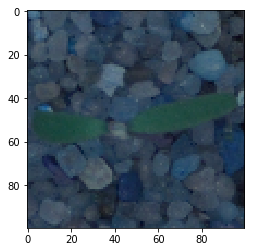

In [132]:
print int(model.predict_classes(x_test[793:],batch_size=2,verbose=1))
print test_id[1]
plt.imshow(x_test[1])
plt.show()

In [162]:
result=list(model.predict_classes(x_test))
res=[plants[x] for x in result]
res

794/794 [==============================] - 0s     


['Small-flowered Cranesbill',
 'Fat Hen',
 'Sugar beet',
 'Common Chickweed',
 'Sugar beet',
 'Loose Silky-bent',
 'Common Chickweed',
 'Fat Hen',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Scentless Mayweed',
 'Sugar beet',
 'Fat Hen',
 'Scentless Mayweed',
 'Scentless Mayweed',
 'Common Chickweed',
 'Cleavers',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Shepherds Purse',
 'Sugar beet',
 'Sugar beet',
 'Maize',
 'Shepherds Purse',
 'Scentless Mayweed',
 'Common Chickweed',
 'Sugar beet',
 'Common Chickweed',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Loose Silky-bent',
 'Common Chickweed',
 'Maize',
 'Loose Silky-bent',
 'Common wheat',
 'Common Chickweed',
 'Small-flowered Cranesbill',
 'Sugar beet',
 'Scentless Mayweed',
 'Maize',
 'Scentless Mayweed',
 'Maize',
 'Small-flowered Cranesbill',
 'Loose Silky-bent',
 'Sugar beet

### Checking out sample submission

In [169]:
sample_sub = pd.read_csv('/home/nishant/Desktop/sample_submission.csv')
sample_sub.head()

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Sugar beet
4,00c47e980.png,Sugar beet


**creation of submission file**

In [167]:
def finalprediction():
    results = [[0,0]]*(x_test.shape[0])
    plants=os.listdir('../nishant/Desktop/train/')
    result=list(model.predict_classes(x_test))
    res=[plants[x] for x in result]
    tid=list(test_id)
    results=[[x,y] for x,y in zip(tid,res)]
    results=np.array(results)
    title=[[0,0]]
    title[0][0]='file'
    title[0][1]='species'
    with open("/home/nishant/Desktop/prediction.csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows(title)
        writer.writerows(results)

In [168]:
finalprediction()

794/794 [==============================] - 0s     


>**Huge improvements can be brought about by careful optimisation of parameters such as image size,augmentation,learning rate,epochs adding more convolutional layers to our model.It shall be a bit time consuming to train and retrain the model with different parameters and visualising the result.**